<a href="https://colab.research.google.com/github/mdparvex/polyp-segmentation/blob/main/UNet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#libraries
import os
import random

import numpy as np
import cv2
from glob import glob
from scipy.ndimage.interpolation import rotate
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
#Process Image Part -1
# Read and Save Image
def read_image(imagefile, grayscale=False):
    if grayscale == True:
        image = cv2.imread(imagefile)
        #image = np.expand_dims(image, -1)
    else:
        image = cv2.imread(imagefile)
    return image

def save_image(image, mask, path, binary=True):
    image = np.array(image)
    if binary == True:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path[0], image)
    cv2.imwrite(path[1], mask)

In [ ]:
#Process Image Part -2
# Data Augmentation
def concat_images(images, rows, cols):
    _, h, w, _ = images.shape
    images = images.reshape((rows, cols, h, w, 3))
    images = images.transpose(0, 2, 1, 3, 4)
    images = images.reshape((rows * h, cols * w, 3))
    return images

def check_size(size):
    if type(size) == int:
        size = (size, size)
    if type(size) != tuple:
        raise TypeError('size is int or tuple')
    return size

def subtract(image):
    image = image / 255
    return image

def resize(image, size):
    size = check_size(size)
    image = cv2.resize(image, size)
    return image

def center_crop(image, mask, crop_size, size):
    h, w, _ = image.shape
    crop_size = check_size(crop_size)
    top = (h - crop_size[0]) // 2 
    left = (w - crop_size[1]) // 2 
    bottom = top + crop_size[0]
    right = left + crop_size[1]

    image = image[top:bottom, left:right, :]
    mask = mask[top:bottom, left:right, :]

    image = resize(image, size)
    mask = resize(mask, size)

    return image, mask

def random_crop(image, mask, crop_size, size):
    crop_size = check_size(crop_size)
    h, w, _ = image.shape
    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])
    bottom = top + crop_size[0]
    right = left + crop_size[1]

    image = image[top:bottom, left:right, :]
    mask = mask[top:bottom, left:right, :]

    image = resize(image, size)
    mask = resize(mask, size)

    return image, mask

def horizontal_flip(image, mask, size):
    image = image[:, ::-1, :]
    mask = mask[:, ::-1, :]

    image = resize(image, size)
    mask = resize(mask, size)

    return image, mask

def vertical_flip(image, mask, size):
    image = image[::-1, :, :]
    mask = mask[::-1, :, :]

    image = resize(image, size)
    mask = resize(mask, size)

    return image, mask

def scale_augmentation(image, mask, scale_range, crop_size, size):
    scale_size = np.random.randint(*scale_range)
    image = cv2.resize(image, (scale_size, scale_size))
    mask = cv2.resize(mask, (scale_size, scale_size))
    image, mask = random_crop(image, mask, crop_size, size)
    return image, mask

def random_rotation(image, mask, size, angle_range=(0, 90)):
    h1, w1, _ = image.shape
    h2, w2, _ = mask.shape

    angle = np.random.randint(*angle_range)
    image = rotate(image, angle)
    image = resize(image, (h1, w1))

    mask = rotate(mask, angle)
    mask = resize(mask, (h2, w2))

    image = resize(image, size)
    mask = resize(mask, size)

    return image, mask

def cutout(image_origin, mask_origin, mask_size, mask_value='mean'):
    image = np.copy(image_origin)
    mask = np.copy(mask_origin)

    if mask_value == 'mean':
        mask_value = image.mean()
    elif mask_value == 'random':
        mask_value = np.random.randint(0, 256)

    h, w, _ = image.shape
    top = np.random.randint(0 - mask_size // 2, h - mask_size)
    left = np.random.randint(0 - mask_size // 2, w - mask_size)
    bottom = top + mask_size
    right = left + mask_size
    if top < 0:
        top = 0
    if left < 0:
        left = 0

    image[top:bottom, left:right, :].fill(mask_value)
    mask[top:bottom, left:right, :].fill(0)

    image = resize(image, size)
    mask = resize(mask, size)

    return image, mask

def brightness_augment(img, mask, factor=0.5):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) #convert to hsv
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 2] = hsv[:, :, 2] * (factor + np.random.uniform()) #scale channel V uniformly
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255 #reset out of range values
    rgb = cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2RGB)

    image = resize(rgb, size)
    mask = resize(mask, size)

    return image, mask

def rgb_to_grayscale(img, mask):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = [img, img, img]
    img = np.transpose(img, (1, 2, 0))

    image = resize(img, size)
    mask = resize(mask, size)
    return image, mask 

In [ ]:
def create_dir(name):
    try:
        os.mkdir(name)
    except:
        pass

In [ ]:
#Process Image Part - 3
"""
train, val, test set creation,
and save those images in a folder named 'new_data'
"""
if __name__ == '__main__':
    ### Image Augmentation
    size = (256, 256)
    crop_size = (300, 300)

    path = "/content/drive/MyDrive/Colab Notebooks/CSE498R"
    dataset_name = "polyp_seg"
    full_path = os.path.join(path, dataset_name)

    new_path = "new_data/"
    create_dir(new_path)
    new_full_path = os.path.join(new_path, dataset_name)

    train_path = os.path.join(new_full_path, "train")
    valid_path = os.path.join(new_full_path, "valid")
    test_path = os.path.join(new_full_path, "test")

    if not os.path.exists(new_full_path):
        os.mkdir(new_full_path)
        for path in [train_path, valid_path, test_path]:
            os.mkdir(path)
            os.mkdir(os.path.join(path, "images"))
            os.mkdir(os.path.join(path, "masks"))

    images = glob(os.path.join(full_path, "images/", "*"))
    masks = glob(os.path.join(full_path, "masks/", "*"))

    images.sort()
    masks.sort()

    len_ids = len(images)
    train_size = int((80/100)*len_ids)
    valid_size = int((10/100)*len_ids)		## Here 10 is the percent of images used for validation
    test_size = int((10/100)*len_ids)		## Here 10 is the percent of images used for testing

    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
    train_masks, test_masks = train_test_split(masks, test_size=test_size, random_state=42)

    train_images, valid_images = train_test_split(train_images, test_size=test_size, random_state=42)
    train_masks, valid_masks = train_test_split(train_masks, test_size=test_size, random_state=42)

    print("Total Size: ", len_ids)
    print("Training Size: ", train_size)
    print("Validation Size: ", valid_size)
    print("Testing Size: ", test_size)

    ## testing images and masks
    for idx, p in tqdm(enumerate(test_images), total=len(test_images)):
        ## Path
        name = p.split("/")[-1].split(".")[0]
        image_path = test_images[idx]
        mask_path = test_masks[idx]

        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = read_image(image_path)
            mask = read_image(mask_path, grayscale=True)

            new_image_path = os.path.join(new_full_path, "test", "images/")
            new_mask_path = os.path.join(new_full_path, "test", "masks/")

            image = resize(image, size)
            mask = resize(mask, size)

            img_path = new_image_path + str(name) + ".jpg"
            mask_path = new_mask_path + str(name) + ".jpg"
            tmp_path = [img_path, mask_path]
            save_image(image, mask, tmp_path)

    ## Validation images and masks
    for idx, p in tqdm(enumerate(valid_images), total=len(valid_images)):
        ## Path
        name = p.split("/")[-1].split(".")[0]
        image_path = valid_images[idx]
        mask_path = valid_masks[idx]

        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = read_image(image_path)
            mask = read_image(mask_path, grayscale=True)

            new_image_path = os.path.join(new_full_path, "valid", "images/")
            new_mask_path = os.path.join(new_full_path, "valid", "masks/")

            image = resize(image, size)
            mask = resize(mask, size)

            img_path = new_image_path + str(name) + ".jpg"
            mask_path = new_mask_path + str(name) + ".jpg"
            tmp_path = [img_path, mask_path]
            save_image(image, mask, tmp_path)

    ## Training images and masks
    for idx, p in tqdm(enumerate(train_images), total=len(train_images)):
        ## Path
        name = p.split("/")[-1].split(".")[0]
        image_path = train_images[idx]
        mask_path = train_masks[idx]

        if os.path.exists(image_path) and os.path.exists(image_path):
            image = read_image(image_path)
            mask = read_image(mask_path, grayscale=True)

            ## Augment
            image1, mask1 = center_crop(image, mask, crop_size, size)
            '''
            image2, mask2 = random_crop(image, mask, crop_size, size)
            image3, mask3 = horizontal_flip(image, mask, size)
            image4, mask4 = vertical_flip(image, mask, size)
            image5, mask5 = scale_augmentation(image, mask, (512, 768), crop_size, size)
            image6, mask6 = random_rotation(image, mask, size)
            image7, mask7 = cutout(image, mask, 256)'''
            ## Extra Cropping
            image8, mask8 = random_crop(image, mask, crop_size, size)
            #image9, mask9 = random_crop(image, mask, crop_size, size)
            ## Extra Scale Augmentation
            image10, mask10 = scale_augmentation(image, mask, (540, 820), crop_size, size)
            #image11, mask11 = scale_augmentation(image, mask, (720, 1024), crop_size, size)
            ## Extra Rotation
            image12, mask12 = random_rotation(image, mask, size)
            #image13, mask13 = random_rotation(image, mask, size)
            ## Brightness
            image14, mask14 = brightness_augment(image, mask, factor=0.3)
            #image15, mask15 = brightness_augment(image, mask, factor=0.6)
            #image16, mask16 = brightness_augment(image, mask, factor=0.9)
            ## More Rotation
            image17, mask17 = random_rotation(image, mask, size)
            #image18, mask18 = random_rotation(image, mask, size)
            ## More Random Crop
            image19, mask19 = random_crop(image, mask, crop_size, size)
            #image20, mask20 = random_crop(image, mask, crop_size, size)
            ## More Cutout
            image21, mask21 = cutout(image, mask, 256)
            #image22, mask22 = cutout(image, mask, 256)
            ## Grayscale
            image23, mask23 = rgb_to_grayscale(image, mask)
            image24, mask24 = rgb_to_grayscale(image1, mask1)
            '''
            image25, mask25 = rgb_to_grayscale(image2, mask2)
            image26, mask26 = rgb_to_grayscale(image3, mask3)
            image27, mask27 = rgb_to_grayscale(image4, mask4)
            image28, mask28 = rgb_to_grayscale(image5, mask5)
            image29, mask29 = rgb_to_grayscale(image15, mask15)
            image30, mask30 = rgb_to_grayscale(image16, mask16)'''

            ## Original image and mask
            image = resize(image, size)
            mask = resize(mask, size)

            ## All images and masks
            all_images = [image, image1,
                image8, image10, image12, image14,
                image17, image19, image21,
                image23,image24
                ]
            all_masks  = [mask, mask1, mask8
                , mask10, mask12, mask14,
                mask17, mask19, mask21,
                mask23, mask24
                ]

            ## Save the images and masks
            new_image_path = os.path.join(new_full_path, "train", "images/")
            new_mask_path = os.path.join(new_full_path, "train", "masks/")

            for j in range(len(all_images)):
                img_path = new_image_path + str(name) + "_" + str(j) + ".jpg"
                msk_path = new_mask_path + str(name) + "_" + str(j) + ".jpg"

                img = all_images[j]
                msk = all_masks[j]
                path = [img_path, msk_path]

                save_image(img, msk, path)

Total Size:  1000
Training Size:  800
Validation Size:  100
Testing Size:  100


100%|██████████| 800/800 [13:05<00:00,  1.02it/s]


IndexError: ignored

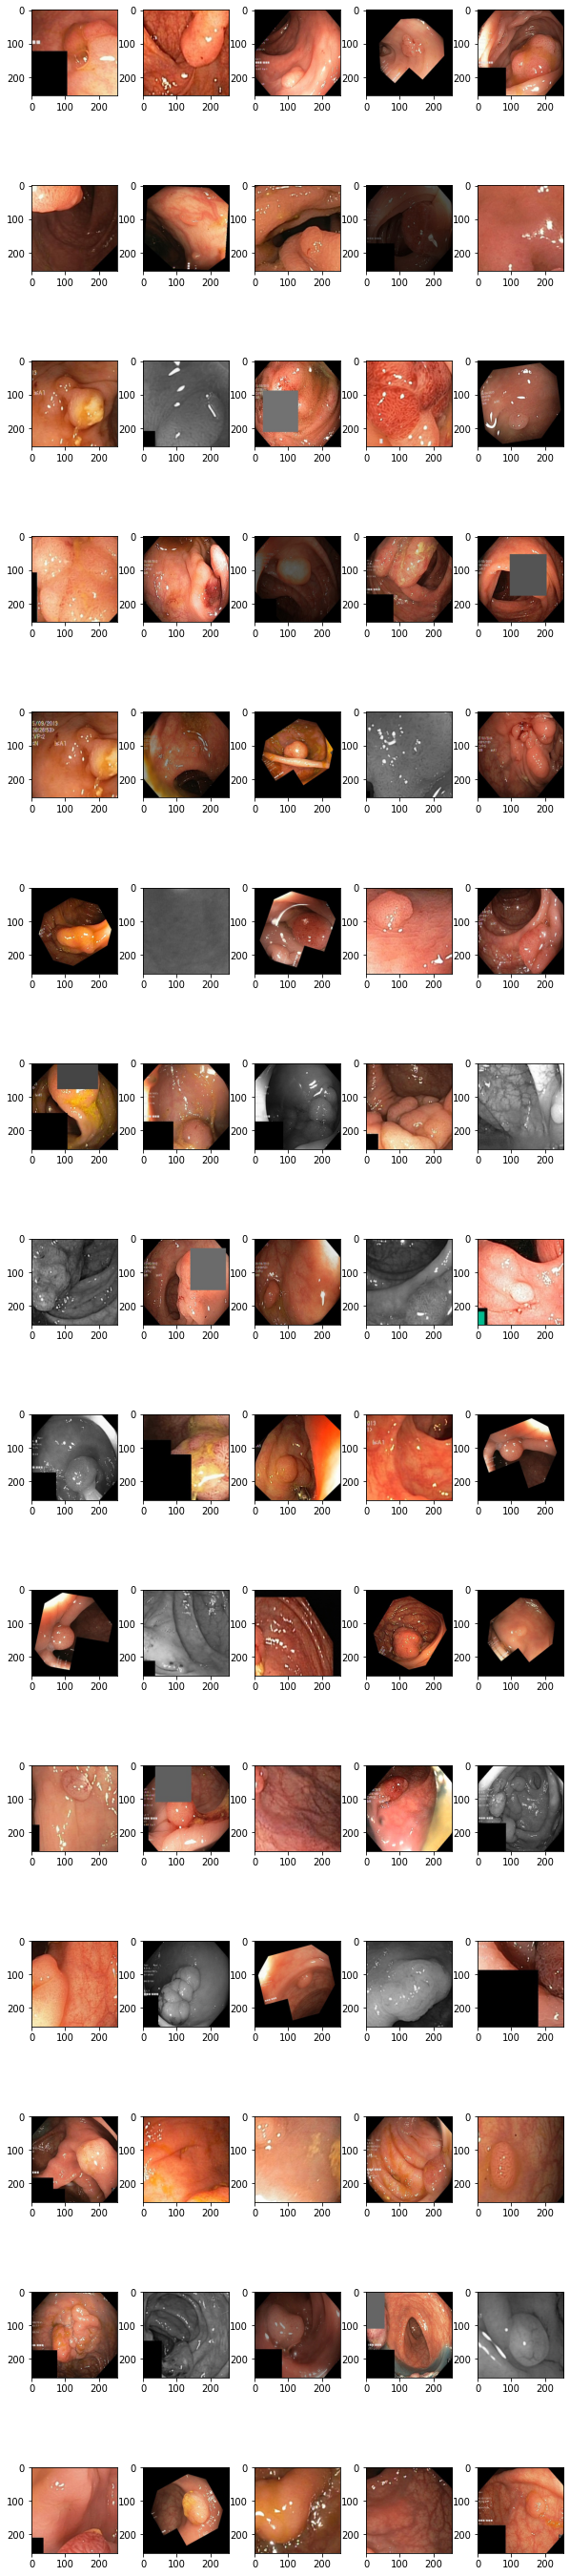

In [ ]:
# Put all images in the folder into a list (works)
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob("/content/new_data/polyp_seg/train/images/*"):
    images.append(np.asarray(Image.open(f)))

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(15, 5, figsize=(10, 50))
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

# This is for displaying the names (works)
for filename in os.listdir('/content/new_data/polyp_seg/train/images/'):
  RatName = filename[:-4]

i = 0
for filename in os.listdir('/content/new_data/polyp_seg/train/images/'):
  RatName = filename[:-4]
  axs[i].imshow(images[i])
  #axs[i].set_title(RatName)
  i += 1


IndexError: ignored

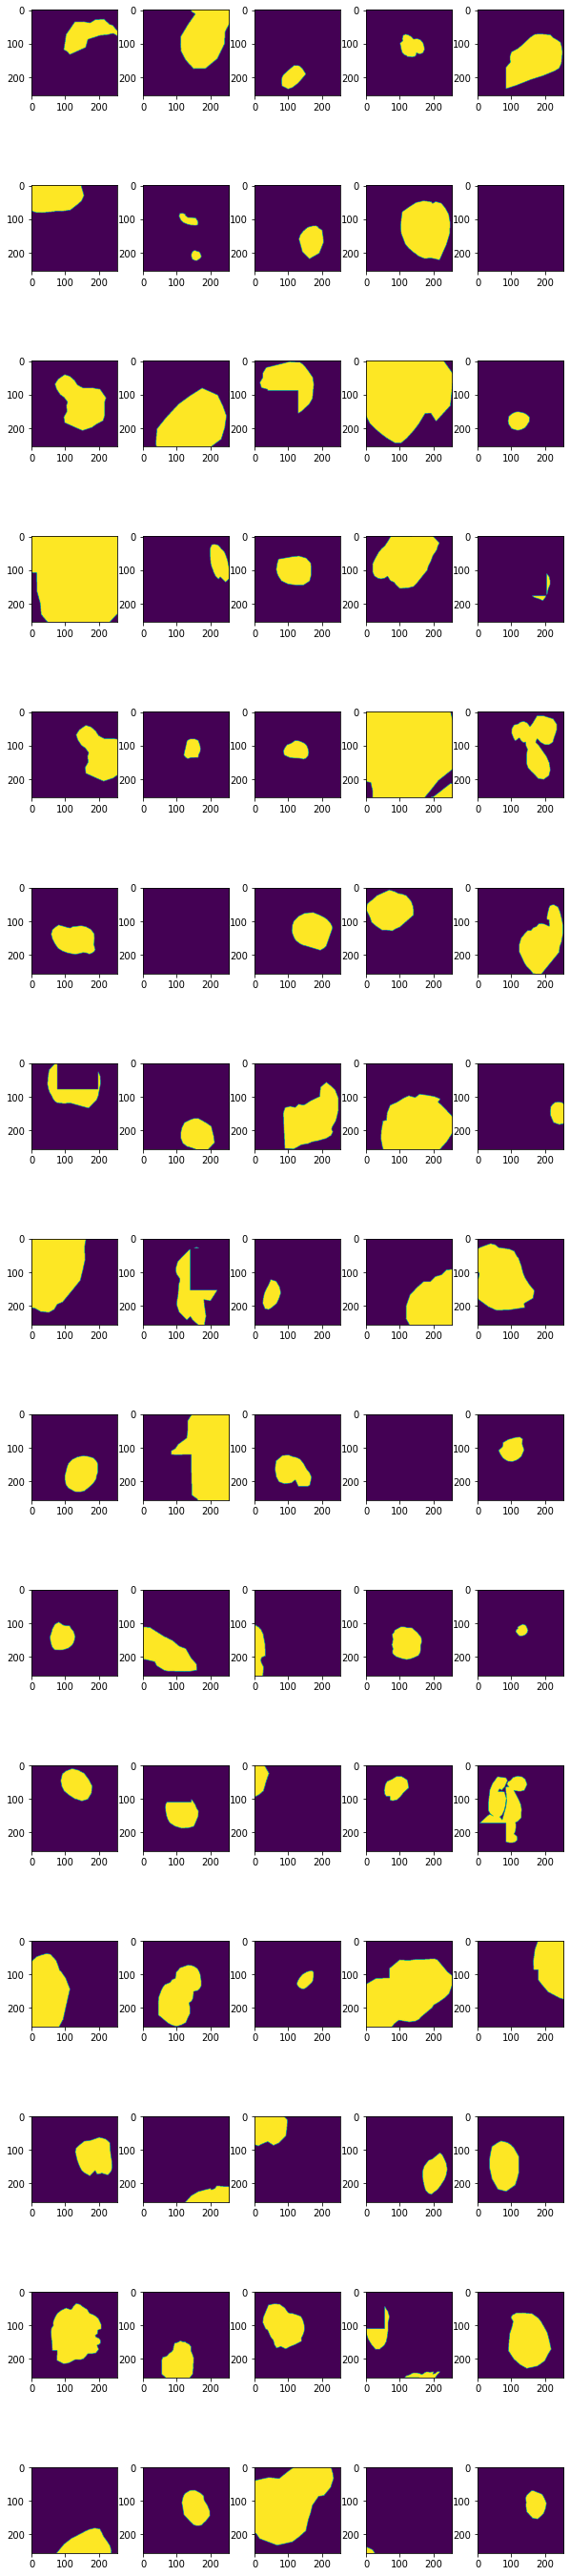

In [ ]:
# Put all images in the folder into a list (works)
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob("/content/new_data/polyp_seg/train/masks/*"):
    images.append(np.asarray(Image.open(f)))

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(15, 5, figsize=(10, 50))
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

# This is for displaying the names (works)
for filename in os.listdir('/content/new_data/polyp_seg/train/masks/'):
  RatName = filename[:-4]

i = 0
for filename in os.listdir('/content/new_data/polyp_seg/train/masks/'):
  RatName = filename[:-4]
  axs[i].imshow(images[i])
  #axs[i].set_title(RatName)
  i += 1


In [ ]:
"""
Data Generator
"""
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

def parse_image(img_path, image_size):
    image_rgb = cv2.imread(img_path, 1)
    h, w, _ = image_rgb.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        image_rgb = cv2.resize(image_rgb, (image_size, image_size))
    image_rgb = image_rgb/255.0
    return image_rgb

def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, -1)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask/255.0

    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path, masks_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]
        masks_path = self.masks_path[index*self.batch_size : (index+1)*self.batch_size]

        images_batch = []
        masks_batch = []

        for i in range(len(images_path)):
            ## Read image and mask
            image = parse_image(images_path[i], self.image_size)
            mask = parse_mask(masks_path[i], self.image_size)

            images_batch.append(image)
            masks_batch.append(mask)

        return np.array(images_batch), np.array(masks_batch)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))

In [ ]:
#Aulternet model

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def build_model():
    size = 256
    num_filters = [32, 64, 128,256, 512]
    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs

    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [ ]:
"""
Model Matrics
"""
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# from data_generator import DataGen
# from m_resunet import ResUnetPlusPlus
# from metrics import dice_coef, dice_loss

if __name__ == "__main__":
    ## Path
    file_path = "files/"
    model_path = "files/unet.h5"

    ## Create files folder
    try:
        os.mkdir("files")
    except:
        pass

    train_path = "new_data/polyp_seg/train/"
    valid_path = "new_data/polyp_seg//valid/"

    ## Training
    train_image_paths = glob(os.path.join(train_path, "images", "*"))
    train_mask_paths = glob(os.path.join(train_path, "masks", "*"))
    train_image_paths.sort()
    train_mask_paths.sort()

    # train_image_paths = train_image_paths[:2000]
    # train_mask_paths = train_mask_paths[:2000]

    ## Validation
    valid_image_paths = glob(os.path.join(valid_path, "images", "*"))
    valid_mask_paths = glob(os.path.join(valid_path, "masks", "*"))
    valid_image_paths.sort()
    valid_mask_paths.sort()

    ## Parameters
    image_size = 256
    batch_size = 8
    lr = 1e-2
    epochs = 100

    train_steps = len(train_image_paths)//batch_size
    valid_steps = len(valid_image_paths)//batch_size

    ## Generator
    train_gen = DataGen(image_size, train_image_paths, train_mask_paths, batch_size=batch_size)
    valid_gen = DataGen(image_size, valid_image_paths, valid_mask_paths, batch_size=batch_size)

    ## Unet
    #arch = Unet(input_size=image_size)
    #model = arch.build_model()

    ## Unet2
    #arch = Unet()
    model = build_model()

    ## ResUnet
    #arch = ResUnet(input_size=image_size)
    #model = arch.build_model()

    ## ResUnet++
    #arch = ResUnetPlusPlus(input_size=image_size)
    #model = arch.build_model()

    # FCN8
    #arch = FCN8(input_size=image_size)
    # model = arch.build_model()

    optimizer = Nadam(lr)
    metrics = [Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
    model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)

    csv_logger = CSVLogger(f"{file_path}unet_{batch_size}.csv", append=False)
    checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, min_lr=1e-4, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=False)
    callbacks = [csv_logger, checkpoint, reduce_lr, early_stopping]

    history=model.fit(train_gen,
            validation_data=valid_gen,
            steps_per_epoch=train_steps,
            validation_steps=valid_steps,
            epochs=epochs,
            callbacks=callbacks)

Epoch 1/100
1100/1100 [==============================] - ETA: 0s - loss: 0.5515 - recall_1: 0.6970 - precision_1: 0.3828 - dice_coef: 0.4485 - mean_io_u_1: 0.4414
Epoch 1: val_loss improved from inf to 0.54782, saving model to files/unet.h5
1100/1100 [==============================] - 129s 109ms/step - loss: 0.5515 - recall_1: 0.6970 - precision_1: 0.3828 - dice_coef: 0.4485 - mean_io_u_1: 0.4414 - val_loss: 0.5478 - val_recall_1: 0.7572 - val_precision_1: 0.3382 - val_dice_coef: 0.4522 - val_mean_io_u_1: 0.5181 - lr: 0.0100
Epoch 2/100
1100/1100 [==============================] - ETA: 0s - loss: 0.5401 - recall_1: 0.6817 - precision_1: 0.3985 - dice_coef: 0.4599 - mean_io_u_1: 0.5054
Epoch 2: val_loss did not improve from 0.54782
1100/1100 [==============================] - 118s 108ms/step - loss: 0.5401 - recall_1: 0.6817 - precision_1: 0.3985 - dice_coef: 0.4599 - mean_io_u_1: 0.5054 - val_loss: 0.6685 - val_recall_1: 0.8332 - val_precision_1: 0.2226 - val_dice_coef: 0.3315 - val_me

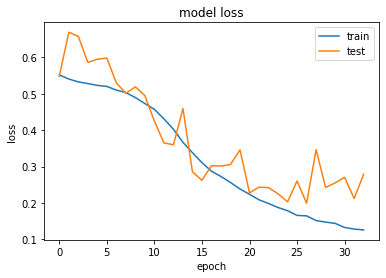

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

if __name__ == "__main__":
    model_path = "files/unet.h5"
    save_path = "result"
    test_path = "new_data/polyp_seg/test/"

    image_size = 256
    batch_size = 1

    test_image_paths = glob(os.path.join(test_path, "images", "*"))
    test_mask_paths = glob(os.path.join(test_path, "masks", "*"))
    test_image_paths.sort()
    test_mask_paths.sort()

    ## Create result folder
    try:
        os.mkdir(save_path)
    except:
        pass

    ## Model
    with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef}):
        model = load_model(model_path)

    ## Test
    print("Test Result: ")
    test_steps = len(test_image_paths)//batch_size
    test_gen = DataGen(image_size, test_image_paths, test_mask_paths, batch_size=batch_size)
    model.evaluate_generator(test_gen, steps=test_steps, verbose=1)

    ## Generating the result
    for i, path in tqdm(enumerate(test_image_paths), total=len(test_image_paths)):
        image = parse_image(test_image_paths[i], image_size)
        mask = parse_mask(test_mask_paths[i], image_size)

        predict_mask = model.predict(np.expand_dims(image, axis=0))[0]
        predict_mask = (predict_mask > 0.5) * 255.0

        sep_line = np.ones((image_size, 10, 3)) * 255

        mask = mask_to_3d(mask)
        predict_mask = mask_to_3d(predict_mask)

        all_images = [image * 255, sep_line, mask * 255, sep_line, predict_mask]
        cv2.imwrite(f"{save_path}/{i}.png", np.concatenate(all_images, axis=1))

    print("Test image generation complete")

Test Result: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


100/100 [==============================] - 2s 10ms/step - loss: 0.2598 - recall_1: 0.6142 - precision_1: 0.9287 - dice_coef: 0.7402 - mean_io_u_1: 0.7502


100%|██████████| 100/100 [00:07<00:00, 13.57it/s]

Test image generation complete


In [ ]:
# Put all images in the folder into a list (works)
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob("/content/result/*"):
    images.append(np.asarray(Image.open(f)))

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(15, 3, figsize=(150, 150))
fig.subplots_adjust(hspace = .3, wspace=.1)
axs = axs.ravel()

# This is for displaying the names (works)
for filename in os.listdir('/content/result/'):
  RatName = filename[:-4]

i = 0
for filename in os.listdir('/content/result/'):
  RatName = filename[:-4]
  axs[i].imshow(images[i])
  #axs[i].set_title(RatName)
  i += 1


In [ ]:
!zip -r /content/result.zip /content/result

  adding: content/result/ (stored 0%)
  adding: content/result/38.png (deflated 3%)
  adding: content/result/92.png (deflated 4%)
  adding: content/result/1.png (deflated 3%)
  adding: content/result/21.png (deflated 3%)
  adding: content/result/96.png (deflated 4%)
  adding: content/result/94.png (deflated 4%)
  adding: content/result/19.png (deflated 3%)
  adding: content/result/31.png (deflated 3%)
  adding: content/result/83.png (deflated 4%)
  adding: content/result/3.png (deflated 2%)
  adding: content/result/41.png (deflated 4%)
  adding: content/result/9.png (deflated 3%)
  adding: content/result/36.png (deflated 3%)
  adding: content/result/77.png (deflated 2%)
  adding: content/result/24.png (deflated 3%)
  adding: content/result/99.png (deflated 3%)
  adding: content/result/57.png (deflated 3%)
  adding: content/result/72.png (deflated 3%)
  adding: content/result/79.png (deflated 3%)
  adding: content/result/28.png (deflated 3%)
  adding: content/result/64.png (deflated 3%)

In [ ]:
from google.colab import files
files.download('/content/result.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>